In [1]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('../data/train/ToM_train_600.parquet')

In [3]:
len(df)

600

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   story_structure     600 non-null    object
 1   infilled_story      600 non-null    object
 2   question            600 non-null    object
 3   answer              600 non-null    object
 4   question_type       600 non-null    object
 5   params              600 non-null    object
 6   nth_order           600 non-null    int64 
 7   is_interesting      600 non-null    bool  
 8   story_type          600 non-null    object
 9   story_structure_wn  600 non-null    object
dtypes: bool(1), int64(1), object(8)
memory usage: 42.9+ KB


In [6]:
df.groupby(['story_type']).params.count()

story_type
all                              45
all+asymmetric                   27
allbutfantom                     43
allbutfantom+asymmetric          58
tomi                             76
tomi+asymmetric                  30
tomi+info-exchange               45
tomi+info-exchange+asymmetric    61
tomi+object-state                62
tomi+object-state+asymmetric     52
tomi+room-changes                36
tomi+room-changes+asymmetric     60
tomi-object-state                 4
tomi-object-state+asymmetric      1
Name: params, dtype: int64

In [7]:
df.groupby(['is_interesting','nth_order']).story_structure.count()

is_interesting  nth_order
False            1            12
                 2            68
True            -1           181
                 1           133
                 2           206
Name: story_structure, dtype: int64

In [14]:
dfs = df.groupby(['answer']).infilled_story.count().reset_index()

In [20]:
dfs = dfs.sort_values(by='infilled_story', ascending=False, ignore_index=True)
dfs.head(20)

,answer,infilled_story
0,plastic storage bin,96
1,cardboard box,46
2,wooden chest,41
3,canvas duffel bag,22
4,wooden box,20
5,metal toolbox,19
6,leather pouch,17
7,toolbox,16
8,wooden desk drawer,15
9,canvas bag,15


In [37]:
df_filtered = df.groupby("nth_order", group_keys=False).apply(
    lambda g: g.groupby("question_type", group_keys=False).apply(
        lambda x: x if len(x) <= 10 else x.sample(10, random_state=42)
    )
)

df_filtered = df_filtered.reset_index(drop=True)

/tmp/ipykernel_109123/480587486.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda g: g.groupby("question_type", group_keys=False).apply(
/tmp/ipykernel_109123/480587486.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda g: g.groupby("question_type", group_keys=False).apply(
/tmp/ipykernel_109123/480587486.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

In [39]:
#df_filtered.groupby(['answer']).infilled_story.count().reset_index()
len(df_filtered)

116

In [40]:
dft = df_filtered.copy()
dft.index = range(len(dft))

In [41]:
#SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>"""

SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

In [42]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [43]:
dft.columns

Index(['story_structure', 'infilled_story', 'question', 'answer',
       'question_type', 'params', 'nth_order', 'is_interesting', 'story_type',
       'story_structure_wn'],
      dtype='object')

In [44]:
dfm = dft.melt(id_vars=['question', 'answer'], value_vars=['infilled_story', 'story_structure', 'story_structure_wn'], var_name='story_group',value_name='story')

In [45]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        prompt.append( [
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i])}
            ])
    return prompt

In [46]:
prompts = get_prompts(dfm)

In [47]:
print(prompts[2][0]['content'])

You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.


In [48]:
print(prompts[2][1]['content'])

Story: A warm, golden light streamed through the stained-glass windows of the chapel, illuminating the polished pews and quiet spaces within the funeral home. The arrangement room, a space dedicated to the careful preparation and planning of tributes, stood adjacent to the chapel, its door slightly ajar. Taylor entered the chapel, its tranquil ambiance a soothing balm for her busy morning, and began a methodical check of the seating, the altar, and every delicate flower arrangement. Each item was scrutinized, her hands instinctively adjusting a stray petal or straightening a candle. As they walked side by side, Taylor found an opportune moment to share her thoughts with Dominic on the carefully curated casket in a soft, yet clear tone. Taylor carefully placed the silver locket in the safety of the leather wallet, its soft creak a reassuring sound in the chapel's quiet atmosphere. The chapel's serene atmosphere was briefly broken by the soft sound of Taylor moving an item to the adjacen

In [49]:
dfm['prompt'] = prompts

In [50]:
data = Dataset.from_pandas(dfm)

In [51]:
data['answer']

['leather briefcase',
 'guitar case',
 'wooden box',
 'canvas duffel bag',
 'canvas duffel bag',
 'wooden desk drawer',
 'guitar case',
 'leather satchel',
 'leather satchel',
 'metal file cabinet',
 'operations room',
 'staff room',
 'press box',
 'waiting lounge',
 'university cafeteria',
 'storage gallery',
 'storage warehouse',
 'main bar area',
 'backstage production office',
 'arrangement room',
 'metal toolbox',
 'metal toolbox',
 'leather pouch',
 'metal lunchbox',
 'wooden desk drawer',
 'leather briefcase',
 'leather pouch',
 'plastic storage bin',
 'leather briefcase',
 'wooden drawer',
 'briefing room',
 'control room',
 'employee break room',
 'chapel',
 'security control room',
 'control room',
 "stadium's main office",
 'art studio',
 'galley',
 'back office',
 'metal toolbox',
 'black plastic storage bin',
 'metal file cabinet',
 'cardboard envelope',
 'leather satchel',
 'plastic storage bin',
 'leather pouch',
 'metal toolbox',
 'metal toolbox',
 'cardboard file box',

In [52]:
len(data['prompt'])

348

<Axes: ylabel='Count'>

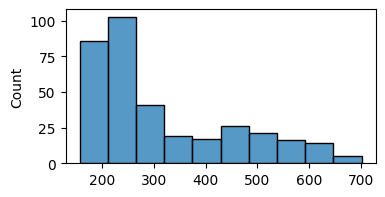

In [53]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [54]:
df_train_ = dfm.iloc[np.arange(len(token_lengths))[token_lengths<512]]
df_train_.index = range(len(df_train_))

In [55]:
data_train = Dataset.from_pandas(df_train_)

In [56]:
data_train

Dataset({
    features: ['question', 'answer', 'story_group', 'story', 'prompt'],
    num_rows: 304
})

In [57]:
data_train.to_parquet('../data/train/ToM_train_single_question_no_step.parquet')

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 252.43ba/s]


720478

In [30]:
import re

In [31]:
def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized




def reward_func_(response, answer):
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    match = re.match(pattern, response, re.DOTALL | re.MULTILINE)
    
    if match:
        response_ = extract_xml_answer(response)
        norm_response = normalize_answer(response_)
        norm_answer = normalize_answer(answer)
        ans_pattern = r"\b(?:in|at|on|inside)?\s*(?:the\s*)?" + re.escape(norm_answer) + r"\b$"
        match = re.match(ans_pattern, norm_response, re.DOTALL | re.MULTILINE)
        if match:
            return 2
        else:
            return 0.5
    else:
        return 0


In [32]:
answer = "<think>think</think><answer>airport terminal gate</answer>"
answer_wrong = "<think>think</think><answer>(2) at the  . 'airport gate'\n </answer>"
answer_p1 = "<think>think</think><answer>'airport terminal gate area.</answer>"
answer_p2 = "<think>think</think><answer>in airport terminal gate.</answer>"

In [33]:
reward_func_(answer, 'airport terminal gate')

2

In [34]:
reward_func_(answer_wrong, 'airport terminal gate')

0.5

In [35]:
reward_func_(answer_p1, 'airport terminal gate')

0.5

In [36]:
reward_func_(answer_p2, 'airport terminal gate')

2